In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import gc

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib


path_submissions = '/'

target_name = 'target'
scores_folds = {}

In [2]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test


# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

In [3]:
# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

In [4]:
# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.std],
        'wap2': [np.sum, np.std],
        'wap3': [np.sum, np.std],
        'wap4': [np.sum, np.std],
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'wap_balance': [np.sum, np.max],
        'price_spread':[np.sum, np.max],
        'price_spread2':[np.sum, np.max],
        'bid_spread':[np.sum, np.max],
        'ask_spread':[np.sum, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.sum, np.max],
        "bid_ask_spread":[np.sum,  np.max],
    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature



In [5]:
# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],
        'order_count':[np.sum,np.max],
        'amount':[np.sum,np.max,np.min],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    
    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars
        
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})
    
    df_lr = pd.DataFrame(lis)
        
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)
    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature



In [6]:
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp
    
    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = 32, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df


In [7]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [8]:
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

Our training set has 428932 rows


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 112 out of 112 | elapsed: 34.5min finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   1 out of   1 | elapsed:    0.2s finished


In [9]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
#train['size_tau_450'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_450'] )
#test['size_tau_450'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_450'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
#train['size_tau_150'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_150'] )
#test['size_tau_150'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_150'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

train['size_tau_100'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_100'] )
test['size_tau_100'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_100'] )

In [10]:
train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
#train['size_tau2_450'] = np.sqrt( 0.25/ train['trade_order_count_sum'] )
#test['size_tau2_450'] = np.sqrt( 0.25/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
#train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
#test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

train['size_tau2_100'] = np.sqrt( 0.88/ train['trade_order_count_sum'] )
test['size_tau2_100'] = np.sqrt( 0.88/ test['trade_order_count_sum'] )
# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']
train['size_tau2_d1'] = train['size_tau2_300'] - train['size_tau2_400']
test['size_tau2_d1'] = test['size_tau2_300'] - test['size_tau2_400']
train['size_tau2_d2'] = train['size_tau2_200'] - train['size_tau2_300']
test['size_tau2_d2'] = test['size_tau2_200'] - test['size_tau2_300']

In [11]:
colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

198

In [12]:
# making agg features
from sklearn.cluster import KMeans
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test.loc[test['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
[3, 6, 9, 18, 61, 63, 86, 97]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
[81]
[8, 80]


In [13]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',     
     'log_return1_realized_volatility_2c1',     
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',     
     'log_return1_realized_volatility_5c1',     
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1', 
     'total_volume_sum_2c1', 
     'total_volume_sum_3c1',
     'total_volume_sum_4c1', 
     'total_volume_sum_5c1', 
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1', 
     'trade_size_sum_2c1', 
     'trade_size_sum_3c1',
     'trade_size_sum_4c1', 
     'trade_size_sum_5c1', 
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_2c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_5c1',
     'trade_order_count_sum_6c1',      
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_2c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_5c1',
     'price_spread_sum_6c1',   
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_2c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_5c1',
     'bid_spread_sum_6c1',       
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_2c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_5c1',
     'ask_spread_sum_6c1',   
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_2c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_5c1',
     'volume_imbalance_sum_6c1',       
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_2c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_5c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_2c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_5c1',
     'size_tau2_6c1'] 

In [14]:
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  


In [15]:
train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

import gc

del mat1,mat2
#del train,test
gc.collect()

21

In [16]:
anom_list = []
for stock_id, tmp_df in train.groupby(['stock_id']):
    if np.sum(np.log(tmp_df['target'])<-8.7) > 0:
        anom_list.append(stock_id)


In [17]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

from sklearn.model_selection import KFold, GroupKFold
import lightgbm as lgb
import copy
seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 7,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 3,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':32,
    'device': 'cpu',
    #'gpu_device_id': 0,
    #'gpu_use_dp': True,
    'verbose': -1}
seed1=42
params1 = {
        'learning_rate': 0.045,        
        'lambda_l1': 0.33,
        'lambda_l2': 0.85,
        'num_leaves': 185,
        #'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.97,
        #'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.80,
        'bagging_freq': 1,
        'min_data_in_leaf': 700,
        'max_depth': 7,
        'categorical_column':[0],
        'seed': seed1,
        'feature_fraction_seed': seed1,
        'bagging_seed': seed1,
        'drop_seed': seed1,
        'data_random_seed': seed1,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'device': 'cpu',
        'n_jobs':-1,
    }
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False


def train_and_evaluate_lgb(train, test, params, eval_idx=True, anom_list=None):
    # Hyperparammeters (just basic)
    train['weight'] = 1.
    if anom_list is not None:
        for anom_idx in anom_list:
            train.loc[train['stock_id']==anom_idx, 'weight'] = 1e-9

    features = [col for col in train.columns if col not in {"time_id", "target", "row_id", "weight"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    #kfold = KFold(n_splits = 5, random_state = 2021, shuffle = True)
    kfold = GroupKFold(n_splits = 5)
    y_target = train.target.values
    time_id = train.time_id.values
    # Iterate through each fold
    #for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, y_target, time_id)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = x_train['weight'] / np.square(y_train)
        val_weights = x_val['weight'] / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=10000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=150,
                          feval = feval_rmspe)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        if eval_idx:
            test_predictions += model.predict(test[features]) / 5
    rmspe_score = rmspe(y, oof_predictions)
    print(f'LGBM out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)
    # Return test predictions
    return oof_predictions, test_predictions



Training fold 1
Training until validation scores don't improve for 150 rounds
[250]	training's rmse: 0.000421737	training's RMSPE: 0.214077	valid_1's rmse: 0.000467734	valid_1's RMSPE: 0.221815
[500]	training's rmse: 0.000399663	training's RMSPE: 0.204192	valid_1's rmse: 0.000463096	valid_1's RMSPE: 0.219673
[750]	training's rmse: 0.000386606	training's RMSPE: 0.198151	valid_1's rmse: 0.000461655	valid_1's RMSPE: 0.219041
[1000]	training's rmse: 0.00037704	training's RMSPE: 0.194012	valid_1's rmse: 0.00046073	valid_1's RMSPE: 0.218703
Early stopping, best iteration is:
[1033]	training's rmse: 0.000376075	training's RMSPE: 0.19332	valid_1's rmse: 0.000460634	valid_1's RMSPE: 0.218502
Training fold 2
Training until validation scores don't improve for 150 rounds
[250]	training's rmse: 0.000421182	training's RMSPE: 0.207307	valid_1's rmse: 0.000468351	valid_1's RMSPE: 0.244918
[500]	training's rmse: 0.000398882	training's RMSPE: 0.197816	valid_1's rmse: 0.000465399	valid_1's RMSPE: 0.24339

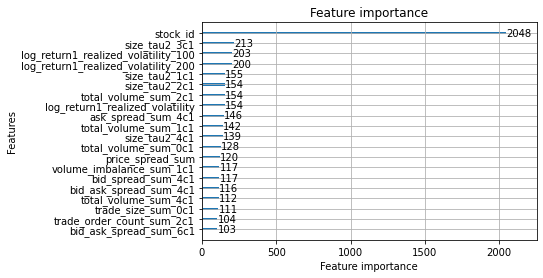

In [18]:
# Traing and evaluate
val_predictions_lgb_0 = copy.copy(train[['stock_id', 'time_id', 'target', 'row_id']])
val_predictions_lgb_0['predictions'] = 0.
test_predictions_lgb_0 = copy.copy(test[['stock_id', 'time_id', 'row_id']])
val_lgb_0, test_lgb_0 = train_and_evaluate_lgb(train, test,params0, True, anom_list)
val_predictions_lgb_0['predictions'] = val_lgb_0
test_predictions_lgb_0['target'] = test_lgb_0

Training fold 1
Training until validation scores don't improve for 150 rounds
[250]	training's rmse: 0.000406671	training's RMSPE: 0.209156	valid_1's rmse: 0.000465817	valid_1's RMSPE: 0.221561
[500]	training's rmse: 0.000383397	training's RMSPE: 0.201131	valid_1's rmse: 0.000463297	valid_1's RMSPE: 0.221453
Early stopping, best iteration is:
[456]	training's rmse: 0.000386231	training's RMSPE: 0.201793	valid_1's rmse: 0.000463403	valid_1's RMSPE: 0.221182
Training fold 2
Training until validation scores don't improve for 150 rounds
[250]	training's rmse: 0.000403783	training's RMSPE: 0.200448	valid_1's rmse: 0.000466287	valid_1's RMSPE: 0.243623
[500]	training's rmse: 0.000381887	training's RMSPE: 0.193018	valid_1's rmse: 0.000464058	valid_1's RMSPE: 0.243631
Early stopping, best iteration is:
[444]	training's rmse: 0.000385902	training's RMSPE: 0.194141	valid_1's rmse: 0.000464284	valid_1's RMSPE: 0.24333
Training fold 3
Training until validation scores don't improve for 150 rounds
[

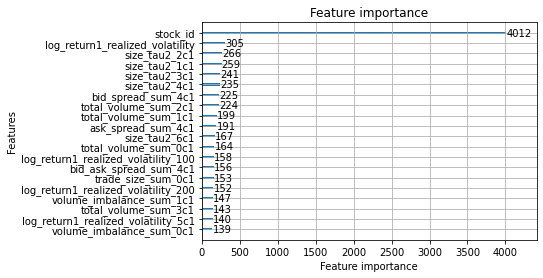

In [19]:
# Traing and evaluate
val_predictions_lgb_1 = copy.copy(train[['stock_id', 'time_id', 'target', 'row_id']])
val_predictions_lgb_1['predictions'] = 0.
test_predictions_lgb_1 = copy.copy(test[['stock_id', 'time_id', 'row_id']])
val_lgb_1, test_lgb_1 = train_and_evaluate_lgb(train, test, params1, True, anom_list)
val_predictions_lgb_1['predictions'] = val_lgb_1
test_predictions_lgb_1['target'] = test_lgb_1

In [20]:
merged_predictions = 0.5 * (val_predictions_lgb_0['predictions'] + val_predictions_lgb_1['predictions'])
#test['target'] = predictions_lgb
#test[['row_id', 'target']].to_csv('submission.csv',index = False)
print("lgbm CV merged: {}".format(rmspe(val_predictions_lgb_0['target'], merged_predictions)))


lgbm CV merged: 0.22584874625746357


In [21]:
clipped_predictions = np.clip(merged_predictions, 1e-4, 0.072)
print("lgbm CV merged and clipped: {}".format(rmspe(val_predictions_lgb_0['target'], clipped_predictions)))

lgbm CV merged and clipped: 0.22584874625746357


In [22]:
#colNames.remove('row_id')
train.replace([np.inf, -np.inf], np.nan,inplace=True)
test.replace([np.inf, -np.inf], np.nan,inplace=True)
qt_train = []
train_nn=train[colNames].copy()
test_nn=test[colNames].copy()
for col in colNames:
    #print(col)
    qt = QuantileTransformer(random_state=21,n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])    
    qt_train.append(qt)

train_nn[['stock_id','time_id','target']]=train[['stock_id','time_id','target']]
test_nn[['stock_id','time_id']]=test[['stock_id','time_id']]

In [23]:
# making agg features
from sklearn.cluster import KMeans
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )
    

mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train_nn.loc[train_nn['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )
    
    newDf = test_nn.loc[test_nn['stock_id'].isin(ind) ]    
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )
    
    n+=1
    
mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])

[1 0 4 2 1 1 2 4 6 2 1 0 4 4 1 1 1 2 4 4 4 0 1 1 3 1 1 4 3 4 3 4 4 1 3 3 4
 3 4 1 4 1 4 4 1 0 4 4 1 0 0 3 3 3 2 0 2 4 1 4 4 1 4 1 0 3 3 0 3 0 6 5 3 3
 0 1 2 0 3 3 3 4 1 1 0 2 3 3 1 0 1 4 4 4 4 4 1 3 1 0 1 4 1 0 1 4 1 0 4 0 4
 0]
[1, 11, 22, 50, 55, 56, 62, 73, 76, 78, 84, 87, 96, 101, 112, 116, 122, 124, 126]
[0, 4, 5, 10, 15, 16, 17, 23, 26, 28, 29, 36, 42, 44, 48, 53, 66, 69, 72, 85, 94, 95, 100, 102, 109, 111, 113, 115, 118, 120]
[3, 6, 9, 18, 61, 63, 86, 97]
[27, 31, 33, 37, 38, 40, 58, 59, 60, 74, 75, 77, 82, 83, 88, 89, 90, 98, 99, 110]
[2, 7, 13, 14, 19, 20, 21, 30, 32, 34, 35, 39, 41, 43, 46, 47, 51, 52, 64, 67, 68, 70, 93, 103, 104, 105, 107, 108, 114, 119, 123, 125]
[81]
[8, 80]


In [24]:
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  


In [25]:
train_nn = pd.merge(train_nn,mat1[nnn],how='left',on='time_id')
test_nn = pd.merge(test_nn,mat2[nnn],how='left',on='time_id')

import gc

del mat1,mat2
#del train#,test
gc.collect()

13013

In [26]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
def root_mean_squared_per_error(y_true, y_pred):
         return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=50, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=16, verbose=0,
    mode='min')

2021-09-27 06:33:29.374140: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 06:33:29.374786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [27]:
#https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from tensorflow.keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
#import tensorflow.keras as keras
#from keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.layers import Activation
#get_custom_objects().update({'swish': Activation(swish)})

#hidden_units = (128,64,32)
#stock_embedding_size = 24
nn_params0 = {
    'hidden_units': (128,64,32),
    'stock_embedding_size': 24,
    'input_size': 268,
}
nn_params1 = {
    'hidden_units': (256,128,64),
    'stock_embedding_size': 32,
    'input_size': 268,
}

cat_data = train_nn['stock_id']

def base_model(params=None):
    if params is None:
        params = {
            'hidden_units': (128,64,32),
            'stock_embedding_size': 24,
            'input_size': 268,
        }
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(params['input_size'],), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, params['stock_embedding_size'], 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in params['hidden_units']:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

In [28]:
def train_and_evaluate_nn(train, test, base_params=None, eval_idx=True):
    target_name='target'
    scores_folds = {}
    model_name = 'NN'
    #pred_name = 'pred_{}'.format(model_name)
    
    n_folds = 5
    # kf = model_selection.KFold(n_splits=n_folds, shuffle=True, random_state=2020)
    scores_folds[model_name] = []
    counter = 1
    
    features_to_consider = list(train)
    
    features_to_consider.remove('time_id')
    features_to_consider.remove('target')
    try:
        features_to_consider.remove('pred_NN')
    except:
        pass
    
    
    train[features_to_consider] = train[features_to_consider].fillna(train[features_to_consider].mean())
    test[features_to_consider] = test[features_to_consider].fillna(train[features_to_consider].mean())
    
    train_predictions_nn = np.zeros(train.shape[0])
    test[target_name] = 0
    test_predictions_nn = np.zeros(test.shape[0])
    kfold = GroupKFold(n_splits = 5)
    y_target = train.target.values
    time_id = train.time_id.values
    # Iterate through each fold
    #for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
    for n_count, (trn_ind, val_ind) in enumerate(kfold.split(train, y_target, time_id)):
        print(f'Training fold {n_count + 1}')
        #print('training: {}'.format(trn_ind))
        #print('val: {}'.format(val_ind))
        X_train, X_test = train.iloc[trn_ind][features_to_consider], train.iloc[val_ind][features_to_consider]
        y_train, y_test = train.iloc[trn_ind][target_name], train.iloc[val_ind][target_name]
        #############################################################################################
        # NN
        #############################################################################################
        
        model = base_model(base_params)
        
        model.compile(
            keras.optimizers.Adam(learning_rate=0.006),
            loss=root_mean_squared_per_error
        )
        
        try:
            features_to_consider.remove('stock_id')
        except:
            pass
        
        num_data = X_train[features_to_consider]
        
        scaler = MinMaxScaler(feature_range=(-1, 1))         
        num_data = scaler.fit_transform(num_data.values)    
        
        cat_data = X_train['stock_id']    
        target =  y_train
        
        num_data_test = X_test[features_to_consider]
        num_data_test = scaler.transform(num_data_test.values)
        cat_data_test = X_test['stock_id']
    
        model.fit([cat_data, num_data], 
                  target,               
                  batch_size=4096,
                  epochs=1000,
                  validation_data=([cat_data_test, num_data_test], y_test),
                  callbacks=[es, plateau],
                  validation_batch_size=len(y_test),
                  shuffle=True,
                 verbose = 1)
    
        preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
        train_predictions_nn[val_ind] = preds
        score = round(rmspe(y_true = y_test, y_pred = preds),5)
        print('Fold {} {}: {}'.format(counter, model_name, score))
        scores_folds[model_name].append(score)
        if eval_idx:
            tt =scaler.transform(test[features_to_consider].values)
            #test_nn[target_name] += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
            test_predictions_nn += model.predict([test['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/n_folds
            #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
           
        counter += 1
        features_to_consider.append('stock_id')
    rmspe_score = rmspe(y_target, train_predictions_nn)
    print("NN folds RMSPE is: {}".format(rmspe_score))
    return train_predictions_nn, test_predictions_nn


In [29]:
# Traing and evaluate
val_predictions_nn_0 = copy.copy(train_nn[['stock_id', 'time_id', 'target']])
val_predictions_nn_0['predictions'] = 0.
test_predictions_nn_0 = copy.copy(test_nn[['stock_id', 'time_id']])
val_nn_0, test_nn_0 = train_and_evaluate_nn(train_nn, test_nn, nn_params0, True)
val_predictions_nn_0['predictions'] = val_nn_0
test_predictions_nn_0['target'] = test_nn_0

Training fold 1


2021-09-27 06:33:37.094142: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-27 06:33:37.097583: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 06:33:37.097629: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-27 06:33:37.097673: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (502fef7f5cfb): /proc/driver/nvidia/version does not exist
2021-09-27 06:33:37.098157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Epoch 1/1000
84/84 [==============================] - 4s 33ms/step - loss: 40.5928 - val_loss: 3.6650
Epoch 2/1000
84/84 [==============================] - 2s 22ms/step - loss: 2.3450 - val_loss: 0.5840
Epoch 3/1000
84/84 [==============================] - 2s 23ms/step - loss: 0.9843 - val_loss: 0.6356
Epoch 4/1000
84/84 [==============================] - 2s 23ms/step - loss: 0.7321 - val_loss: 0.7185
Epoch 5/1000
84/84 [==============================] - 2s 23ms/step - loss: 0.6417 - val_loss: 0.6811
Epoch 6/1000
84/84 [==============================] - 2s 23ms/step - loss: 0.6218 - val_loss: 0.4742
Epoch 7/1000
84/84 [==============================] - 2s 22ms/step - loss: 0.5950 - val_loss: 0.6155
Epoch 8/1000
84/84 [==============================] - 2s 23ms/step - loss: 0.6133 - val_loss: 0.4648
Epoch 9/1000
84/84 [==============================] - 2s 23ms/step - loss: 0.6022 - val_loss: 0.5336
Epoch 10/1000
84/84 [==============================] - 2s 23ms/step - loss: 0.5898 - val_l

In [30]:
# Traing and evaluate
val_predictions_nn_1 = copy.copy(train_nn[['stock_id', 'time_id', 'target']])
val_predictions_nn_1['predictions'] = 0.
test_predictions_nn_1 = copy.copy(test_nn[['stock_id', 'time_id']])
val_nn_1, test_nn_1 = train_and_evaluate_nn(train_nn, test_nn, nn_params1, True)
val_predictions_nn_1['predictions'] = val_nn_1
test_predictions_nn_1['target'] = test_nn_1

Training fold 1
Epoch 1/1000
84/84 [==============================] - 4s 45ms/step - loss: 86.3977 - val_loss: 10.4478
Epoch 2/1000
84/84 [==============================] - 3s 40ms/step - loss: 4.5700 - val_loss: 2.6491
Epoch 3/1000
84/84 [==============================] - 3s 39ms/step - loss: 5.3918 - val_loss: 8.1808
Epoch 4/1000
84/84 [==============================] - 3s 40ms/step - loss: 3.1986 - val_loss: 1.1894
Epoch 5/1000
84/84 [==============================] - 3s 39ms/step - loss: 1.4986 - val_loss: 3.6919
Epoch 6/1000
84/84 [==============================] - 3s 39ms/step - loss: 4.9792 - val_loss: 8.3392
Epoch 7/1000
84/84 [==============================] - 3s 39ms/step - loss: 5.1459 - val_loss: 6.4743
Epoch 8/1000
84/84 [==============================] - 4s 49ms/step - loss: 3.7412 - val_loss: 1.2576
Epoch 9/1000
84/84 [==============================] - 4s 52ms/step - loss: 3.3331 - val_loss: 1.6966
Epoch 10/1000
84/84 [==============================] - 3s 41ms/step - los

In [31]:
merged_predictions_nn = 0.5 * (val_predictions_nn_0['predictions'] + val_predictions_nn_1['predictions'])
#test['target'] = predictions_lgb
#test[['row_id', 'target']].to_csv('submission.csv',index = False)
print("NN CV merged: {}".format(rmspe(val_predictions_nn_0['target'], merged_predictions_nn)))


NN CV merged: 0.2110056647065544


In [32]:
clipped_predictions_nn = np.clip(merged_predictions_nn, 1e-4, 0.072)
print("NN CV merged and clipped: {}".format(rmspe(val_predictions_nn_0['target'], clipped_predictions_nn)))

NN CV merged and clipped: 0.21099788966822008


In [33]:
merged_predictions_all = 0.5 * (merged_predictions + merged_predictions_nn)
print("lgbm + NN CV merged: {}".format(rmspe(val_predictions_nn_0['target'], merged_predictions_all)))

lgbm + NN CV merged: 0.21396948672978533


In [34]:
clipped_predictions_all = np.clip(merged_predictions_all, 1e-4, 0.072)
print("lgbm + NN CV merged and clipped: {}".format(rmspe(val_predictions_nn_0['target'], clipped_predictions_all)))

lgbm + NN CV merged and clipped: 0.21396948672978533


In [35]:
test['target'] = 0.5 * (0.5 * (test_predictions_lgb_0['target']+ test_predictions_lgb_1['target'])+
                        0.5 * (test_predictions_nn_0['target'] + test_predictions_nn_1['target']))